## Introduction

This notebook is designed to train PrePR-CT and reproduce the results using the McFarland dataset. Before running the notebook, please ensure you have set the correct paths for the input and output files:

- **Data Path**: The location of the dataset files.
- **Results Path**: The directory where the output results will be saved.
- **Models Path**: The directory to save model checkpoints.
- **parent_dir**: The location of the cell type graphs

```python
data_path = "/ibex/scratch/alsulara/Cell-Type-Specific-Graphs/Data/"
save_path_results = "/ibex/scratch/alsulara/Cell-Type-Specific-Graphs/Results/"
save_path_models = "/ibex/scratch/alsulara/Cell-Type-Specific-Graphs/model_checkpoints/"
parent_dir = "/ibex/scratch/alsulara/Cell-Type-Specific-Graphs/graphs/"

In [1]:
import scanpy as sc 
import pandas as pd
import os
import sys
import numpy as np
import gzip
import matplotlib.pyplot as pl
from statistics import mode
from numpy.random import RandomState
from sklearn.metrics.pairwise import euclidean_distances
import re
import seaborn as sns
from scipy.io import mmread
import pickle
from scipy.sparse import csr_matrix
from sklearn import preprocessing
import pickle
from torch_geometric.data import InMemoryDataset, Data, DataLoader
from torch_geometric.utils import *
import tqdm.notebook as tq
import shutil
import sys 
sys.path.insert(0, '../')
import utils
import optuna
from importlib import reload
reload(utils)
from utils import *
from IPython.display import clear_output as clr
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
import model
from importlib import reload
reload(model)
from model import *
from transformers import AutoModelForMaskedLM
from transformers import AutoTokenizer
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
data_path = "/ibex/scratch/alsulara/Cell-Type-Specific-Graphs/Data/"
save_path_results = "/ibex/scratch/alsulara/Cell-Type-Specific-Graphs/Results/"
save_path_models = "/ibex/scratch/alsulara/Cell-Type-Specific-Graphs/model_checkpoints/"


2024-07-15 10:07:33.451678: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
2024-07-15 10:07:37.242696: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/ot/backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


## Import the Data

In [2]:
adata = sc.read(data_path+'McFarland.h5ad')
adata = adata[~adata.obs.condition.isin(['BRD3379','AZD5591'])].copy()
adata

AnnData object with n_obs × n_vars = 16208 × 5000
    obs: 'DepMap_ID', 'cancer', 'cell_det_rate', 'cell_type', 'cell_quality', 'channel', 'disease', 'dose_unit', 'dose_value', 'doublet_CL1', 'doublet_CL2', 'doublet_GMM_prob', 'doublet_dev_imp', 'doublet_z_margin', 'hash_assignment', 'hash_tag', 'num_SNPs', 'organism', 'percent.mito', 'condition', 'perturbation_type', 'sex', 'singlet_ID', 'singlet_dev', 'singlet_dev_z', 'singlet_margin', 'singlet_z_margin', 'time', 'tissue_type', 'tot_reads', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo', 'chembl-ID', 'n_counts', 'drug_dose_name', 'cov_drug_dose_name', 'cov_drug', 'condition_label', 'SEACell'
    var: 'ensembl_id', 'ncounts', 'ncells', 'mt', 'ribo', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_type_colors', 'condition_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

## Embed the compound structures using ChemBERTa

In [3]:
chemberta = AutoModelForMaskedLM.from_pretrained("DeepChem/ChemBERTa-77M-MTR")
tokenizer = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-77M-MTR")

chemberta.eval()
def featurize_ChemBERTa(smiles_list, padding=True):
    embeddings_cls = torch.zeros(len(smiles_list), 600)
    embeddings_mean = torch.zeros(len(smiles_list), 600)

    with torch.no_grad():
        for i, smiles in enumerate(tqdm(smiles_list)):
            encoded_input = tokenizer(smiles, return_tensors="pt",padding=padding,truncation=True)
            model_output = chemberta(**encoded_input)
            
            embedding = model_output[0][::,0,::]
            embeddings_cls[i] = embedding
            
            embedding = torch.mean(model_output[0],1)
            embeddings_mean[i] = embedding
            
    return embeddings_cls.numpy(), embeddings_mean.numpy()

Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
from rdkit import Chem
# Define a list of drugs and their corresponding SMILES strings
drug_smiles = {
    'Trametinib' : 'CN1C(=O)C(C)=C2N(C(=O)N(C3CC3)C(=O)C2=C1NC1=CC=C(I)C=C1F)C1=CC(NC(C)=O)=CC=C1',
    'Dabrafenib' : 'CC(C)(C)C1=NC(=C(S1)C1=NC(N)=NC=C1)C1=C(F)C(NS(=O)(=O)C2=C(F)C=CC=C2F)=CC=C1',
    'Gemcitabine' : 'NC1=NC(=O)N(C=C1)[C@@H]1O[C@H](CO)[C@@H](O)C1(F)F',
    'Navitoclax' : '[H][C@@](CCN1CCOCC1)(CSC1=CC=CC=C1)NC1=C(C=C(C=C1)S(=O)(=O)NC(=O)C1=CC=C(C=C1)N1CCN(CC2=C(CCC(C)(C)C2)C2=CC=C(Cl)C=C2)CC1)S(=O)(=O)C(F)(F)F',
    'Taselisib' :'CC(C)N1N=C(C)N=C1C1=CN2CCOC3=CC(=CC=C3C2=N1)C1=CN(N=C1)C(C)(C)C(N)=O',
    'Everolimus' : '[H][C@@]1(C[C@@H](C)[C@]2([H])CC(=O)[C@H](C)\C=C(C)\[C@@H](O)[C@@H](OC)C(=O)[C@H](C)C[C@H](C)\C=C\C=C\C=C(C)\[C@H](C[C@]3([H])CC[C@@H](C)[C@@](O)(O3)C(=O)C(=O)N3CCCC[C@@]3([H])C(=O)O2)OC)CC[C@@H](OCCO)[C@@H](C1)OC',
    'Idasanutlin' : 'COC1=CC(=CC=C1NC(=O)[C@@H]1N[C@@H](CC(C)(C)C)[C@@](C#N)([C@H]1C1=CC=CC(Cl)=C1F)C1=CC=C(Cl)C=C1F)C(O)=O',
    'Afatinib': 'CN(C)C\C=C\C(=O)NC1=C(O[C@H]2CCOC2)C=C2N=CN=C(NC3=CC(Cl)=C(F)C=C3)C2=C1',
    'Bortezomib' : 'CC(C)C[C@H](NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)C1=CN=CC=N1)B(O)O',
    'JQ1' : 'CC1=C(C)C2=C(S1)N1C(C)=NN=C1[C@H](CC(=O)OC(C)(C)C)N=C2C1=CC=C(Cl)C=C1',
    'Prexasertib' : 'COC1=CC=CC(OCCCN)=C1C1=CC(NC2=CN=C(C=N2)C#N)=NN1',
    'control' : 'CS(C)=O'    
}

# Check if SMILES strings are canonical
canonical_smiles = {}
canonical_smiles_text = {}
for drug_name, smiles in drug_smiles.items():
    # Convert SMILES to RDKit molecule object
    print(smiles)
    mol = Chem.MolToSmiles(Chem.MolFromSmiles(smiles), canonical=True)
    print(mol)
    canonical_smiles_text[drug_name] = mol
    canonical_smiles[drug_name] = featurize_ChemBERTa([mol])[1]

CN1C(=O)C(C)=C2N(C(=O)N(C3CC3)C(=O)C2=C1NC1=CC=C(I)C=C1F)C1=CC(NC(C)=O)=CC=C1
CC(=O)Nc1cccc(-n2c(=O)n(C3CC3)c(=O)c3c(Nc4ccc(I)cc4F)n(C)c(=O)c(C)c32)c1


100%|██████████| 1/1 [00:00<00:00, 141.65it/s]


CC(C)(C)C1=NC(=C(S1)C1=NC(N)=NC=C1)C1=C(F)C(NS(=O)(=O)C2=C(F)C=CC=C2F)=CC=C1
CC(C)(C)c1nc(-c2cccc(NS(=O)(=O)c3c(F)cccc3F)c2F)c(-c2ccnc(N)n2)s1


100%|██████████| 1/1 [00:00<00:00, 219.57it/s]


NC1=NC(=O)N(C=C1)[C@@H]1O[C@H](CO)[C@@H](O)C1(F)F
Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)C2(F)F)c(=O)n1


100%|██████████| 1/1 [00:00<00:00, 272.13it/s]


[H][C@@](CCN1CCOCC1)(CSC1=CC=CC=C1)NC1=C(C=C(C=C1)S(=O)(=O)NC(=O)C1=CC=C(C=C1)N1CCN(CC2=C(CCC(C)(C)C2)C2=CC=C(Cl)C=C2)CC1)S(=O)(=O)C(F)(F)F
CC1(C)CCC(c2ccc(Cl)cc2)=C(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(N[C@H](CCN5CCOCC5)CSc5ccccc5)c(S(=O)(=O)C(F)(F)F)c4)cc3)CC2)C1


100%|██████████| 1/1 [00:00<00:00, 129.99it/s]


CC(C)N1N=C(C)N=C1C1=CN2CCOC3=CC(=CC=C3C2=N1)C1=CN(N=C1)C(C)(C)C(N)=O
Cc1nc(-c2cn3c(n2)-c2ccc(-c4cnn(C(C)(C)C(N)=O)c4)cc2OCC3)n(C(C)C)n1


100%|██████████| 1/1 [00:00<00:00, 217.02it/s]


[H][C@@]1(C[C@@H](C)[C@]2([H])CC(=O)[C@H](C)\C=C(C)\[C@@H](O)[C@@H](OC)C(=O)[C@H](C)C[C@H](C)\C=C\C=C\C=C(C)\[C@H](C[C@]3([H])CC[C@@H](C)[C@@](O)(O3)C(=O)C(=O)N3CCCC[C@@]3([H])C(=O)O2)OC)CC[C@@H](OCCO)[C@@H](C1)OC
CO[C@H]1C[C@@H]2CC[C@@H](C)[C@@](O)(O2)C(=O)C(=O)N2CCCC[C@H]2C(=O)O[C@H]([C@H](C)C[C@@H]2CC[C@@H](OCCO)[C@H](OC)C2)CC(=O)[C@H](C)/C=C(\C)[C@@H](O)[C@@H](OC)C(=O)[C@H](C)C[C@H](C)/C=C/C=C/C=C/1C


100%|██████████| 1/1 [00:00<00:00, 139.24it/s]


COC1=CC(=CC=C1NC(=O)[C@@H]1N[C@@H](CC(C)(C)C)[C@@](C#N)([C@H]1C1=CC=CC(Cl)=C1F)C1=CC=C(Cl)C=C1F)C(O)=O
COc1cc(C(=O)O)ccc1NC(=O)[C@@H]1N[C@@H](CC(C)(C)C)[C@](C#N)(c2ccc(Cl)cc2F)[C@H]1c1cccc(Cl)c1F


100%|██████████| 1/1 [00:00<00:00, 213.58it/s]


CN(C)C\C=C\C(=O)NC1=C(O[C@H]2CCOC2)C=C2N=CN=C(NC3=CC(Cl)=C(F)C=C3)C2=C1
CN(C)C/C=C/C(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc1O[C@H]1CCOC1


100%|██████████| 1/1 [00:00<00:00, 238.58it/s]


CC(C)C[C@H](NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)C1=CN=CC=N1)B(O)O
CC(C)C[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)c1cnccn1)B(O)O


100%|██████████| 1/1 [00:00<00:00, 260.48it/s]


CC1=C(C)C2=C(S1)N1C(C)=NN=C1[C@H](CC(=O)OC(C)(C)C)N=C2C1=CC=C(Cl)C=C1
Cc1sc2c(c1C)C(c1ccc(Cl)cc1)=N[C@@H](CC(=O)OC(C)(C)C)c1nnc(C)n1-2


100%|██████████| 1/1 [00:00<00:00, 245.76it/s]


COC1=CC=CC(OCCCN)=C1C1=CC(NC2=CN=C(C=N2)C#N)=NN1
COc1cccc(OCCCN)c1-c1cc(Nc2cnc(C#N)cn2)n[nH]1


100%|██████████| 1/1 [00:00<00:00, 268.04it/s]


CS(C)=O
CS(C)=O


100%|██████████| 1/1 [00:00<00:00, 317.92it/s]


## Import the Cell Type Graphs in a Dictionary Form

In [5]:
cell_type_network = {}
# Leaf directory 
directory = "McFarland"
# Parent Directories 
parent_dir = "/ibex/scratch/alsulara/Cell-Type-Specific-Graphs/graphs/"
# Path 
path = os.path.join(parent_dir, directory)
print(path)
try: 
    os.makedirs(path) 
except:
    print("File exists!")
max_nodes = 0
genes_pos = []
for cell_type in adata.obs.cell_type.unique():
    print(cell_type)
    cell_type_network[cell_type] = torch.load(os.path.join(path,cell_type+'_coexpr_graph.pkl'))
    if cell_type_network[cell_type].num_nodes >= max_nodes:
        max_nodes = cell_type_network[cell_type].num_nodes
print(max_nodes)
cell_type_network    

/ibex/scratch/alsulara/Cell-Type-Specific-Graphs/graphs/McFarland
File exists!
COLO680N
TEN
RCC10RGB
LNCAPCLONEFGC
BICR31
4510


{'COLO680N': Data(x=[4401, 11], edge_index=[2, 122653], edge_attr=[122653], pos=[4401]),
 'TEN': Data(x=[3290, 9], edge_index=[2, 122677], edge_attr=[122677], pos=[3290]),
 'RCC10RGB': Data(x=[4510, 6], edge_index=[2, 122733], edge_attr=[122733], pos=[4510]),
 'LNCAPCLONEFGC': Data(x=[2916, 15], edge_index=[2, 122580], edge_attr=[122580], pos=[2916]),
 'BICR31': Data(x=[4387, 17], edge_index=[2, 122651], edge_attr=[122651], pos=[4387])}

## Identify the testing drugs based on the E-distance from the control

In [6]:
testing_cell = 'LNCAPCLONEFGC'
from scperturb import *
estats = edist(adata[adata.obs.cell_type == testing_cell].copy(), obs_key='condition', obsm_key='X_pca', dist='sqeuclidean')
# testing_drug = estats.idxmax(axis = 1).loc['control']
# print(testing_drug)
# estats.loc['control']
# estats
testing_drugs = ['Bortezomib', 'JQ1', 'Gemcitabine']

100%|██████████| 12/12 [00:00<00:00, 90.27it/s]


## Compute DEGs per cell type and drug

In [7]:
adata.uns['gene_network'] = {}
adata.uns['rank_genes_groups_cov_DEGs'] = {}
for cell_type in adata.obs.cov_drug.unique():
    if cell_type.split('_')[1] != 'control':
        adata_cov = adata[(adata.obs.cov_drug == cell_type) | (adata.obs.cov_drug == cell_type.split('_')[0]+'_control'), 
        cell_type_network[cell_type.split('_')[0]].pos.tolist()].copy()
        adata_cov.uns['log1p']['base'] = None
        sc.tl.rank_genes_groups(adata_cov, groupby = 'cov_drug',rankby_abs = True,
                                        reference = cell_type.split('_')[0]+'_control',n_genes = len(adata_cov.var))
        dedf = sc.get.rank_genes_groups_df(adata_cov, group=cell_type)
        dedf = dedf.loc[dedf['pvals_adj'] < 0.05].copy()
        # plt.figure()
        # plt.scatter(x=dedf['logfoldchanges'],y=dedf['pvals_adj'].apply(lambda x:-np.log10(x)),s=10)
        # plt.xlabel("logfoldchanges")
        # plt.ylabel("-log10(p_value)")
        # plt.show()
        DEGs_name = rank_genes(dedf)
        df = adata_cov.var.reset_index()
        adata.uns['gene_network'][cell_type] = cell_type_network[cell_type.split('_')[0]].pos.tolist()
        adata.uns['rank_genes_groups_cov_DEGs'][cell_type] = DEGs_name
        pd.DataFrame(DEGs_name).to_csv(save_path_results+"McFarland_"+cell_type+"_DEGs_name.csv")
        pd.DataFrame(adata_cov.var.index.values).to_csv(save_path_results+"McFarland_"+cell_type+"_all_genes.csv")

## Split the data 

In [8]:
adata.obs["dose_value"] = 1.0
adata.obs['cov_drug'] = adata.obs.cell_type.astype(str) + '_' + adata.obs.condition.astype(str)
label_encoder = preprocessing.LabelEncoder()
adata.obs["condition_label"] = label_encoder.fit_transform(adata.obs["condition"])
num_perts = adata.obs["condition_label"].max()+1
adata.obs['split'] = 'train'
adata.obs.loc[(adata.obs.cell_type == testing_cell) & (adata.obs["condition"].isin(testing_drugs)), 'split'] = 'ood'
valid_idx = sc.pp.subsample(adata[(adata.obs['split'] != "ood") & (adata.obs['condition'] != "control")], 0.20, copy=True, random_state = 42).obs.index
adata.obs["split"].loc[valid_idx] = "valid"
display(adata.obs.split.value_counts())

/tmp/ipykernel_1853417/2065125377.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["split"].loc[valid_idx] = "valid"


split
train    13229
valid     2577
ood        402
Name: count, dtype: int64

## Match Control to Treatment Cells

In [9]:
stim_data = adata[adata.obs.condition != 'control'].copy()
stim_data.layers['ctrl_x'] = stim_data.X.A
#stim_data = sc.pp.subsample(stim_data, fraction = 0.80, copy = True)
ctrl_data = adata[adata.obs.condition == 'control'].copy()
# ctrl_data_tensor = {}
## assign one ctrl cell to each perturbed cell within the same cell type
for cell_type in adata.obs.cell_type.unique():
    genes = cell_type_network[cell_type].pos.tolist()
    cell_type_network[cell_type].x = torch.mean(torch.tensor(ctrl_data[ctrl_data.obs.cell_type == cell_type, genes].copy().X.A), dim = 0)
    std = torch.std(torch.tensor(ctrl_data[ctrl_data.obs.cell_type == cell_type, genes].copy().X.A), dim = 0)
    cell_type_network[cell_type].x = torch.cat([cell_type_network[cell_type].x.unsqueeze(1), std.unsqueeze(1)], dim = 1)    


for cov_drug in stim_data.obs.cov_drug.unique():
    cell_type = cov_drug.split('_')[0]
    ad_ctrl = ctrl_data[ctrl_data.obs.cell_type == cell_type].copy()
    ad_stim = stim_data[stim_data.obs.cov_drug == cov_drug].copy()
    num_samples = len(ad_stim)
    sele_samples = balance_subsample(np.array(ad_ctrl.obs.index.values.tolist()), np.array(ad_ctrl.obs.SEACell.values.tolist()), num_samples)
    stim_data[ ad_stim.obs.index.values,: ].layers['ctrl_x'] = ad_ctrl[sele_samples, :].copy().X.A

## Save the data in a form of PyG Data objects to train GNN

In [10]:
cells_train = create_cells(stim_data[stim_data.obs.split == 'train'].copy(), cell_type_network, canonical_smiles)
cells_valid = create_cells(stim_data[stim_data.obs.split == 'valid'].copy(), cell_type_network, canonical_smiles)
cells_ood = create_cells(stim_data[stim_data.obs.split == 'ood'].copy(), cell_type_network, canonical_smiles)

with open(data_path+'cells_train_McFarland.pkl', 'wb') as f:
    pickle.dump(cells_train, f)
with open(data_path+'cells_valid_McFarland.pkl', 'wb') as f:
    pickle.dump(cells_valid, f)
with open(data_path+'cells_ood_McFarland.pkl', 'wb') as f:
    pickle.dump(cells_ood, f)

['TEN', 'RCC10RGB', 'LNCAPCLONEFGC', 'COLO680N', 'BICR31']
Categories (5, object): ['BICR31', 'COLO680N', 'LNCAPCLONEFGC', 'RCC10RGB', 'TEN'] ['Navitoclax', 'Taselisib', 'Everolimus', 'Idasanutlin', 'Bortezomib', ..., 'Afatinib', 'Dabrafenib', 'Gemcitabine', 'JQ1', 'Prexasertib']
Length: 11
Categories (11, object): ['Afatinib', 'Bortezomib', 'Dabrafenib', 'Everolimus', ..., 'Navitoclax', 'Prexasertib', 'Taselisib', 'Trametinib']


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/234 [00:00<?, ?it/s]

  0%|          | 0/433 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/293 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/961 [00:00<?, ?it/s]

  0%|          | 0/1908 [00:00<?, ?it/s]

  0%|          | 0/1101 [00:00<?, ?it/s]

  0%|          | 0/1474 [00:00<?, ?it/s]

  0%|          | 0/730 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

['COLO680N', 'TEN', 'RCC10RGB', 'LNCAPCLONEFGC', 'BICR31']
Categories (5, object): ['BICR31', 'COLO680N', 'LNCAPCLONEFGC', 'RCC10RGB', 'TEN'] ['Navitoclax', 'Taselisib', 'Everolimus', 'Idasanutlin', 'Bortezomib', ..., 'Afatinib', 'Dabrafenib', 'Gemcitabine', 'JQ1', 'Prexasertib']
Length: 11
Categories (11, object): ['Afatinib', 'Bortezomib', 'Dabrafenib', 'Everolimus', ..., 'Navitoclax', 'Prexasertib', 'Taselisib', 'Trametinib']


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/491 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

['LNCAPCLONEFGC']
Categories (1, object): ['LNCAPCLONEFGC'] ['Bortezomib', 'Gemcitabine', 'JQ1']
Categories (3, object): ['Bortezomib', 'Gemcitabine', 'JQ1']


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/325 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

In [11]:
with open(data_path+'cells_train_McFarland.pkl', 'rb') as pickle_file:
    cells_train = pickle.load(pickle_file)

with open(data_path+'cells_valid_McFarland.pkl', 'rb') as pickle_file:
    cells_valid = pickle.load(pickle_file)

with open(data_path+'cells_ood_McFarland.pkl', 'rb') as pickle_file:
    cells_ood = pickle.load(pickle_file)
    
print(len(cells_train), len(cells_valid), len(cells_ood))

10312 2577 402


## Train & test the model

128
Training Starts


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 0, train loss: 26.1963036107082


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 1, train loss: 22.06471274880802


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 2, train loss: 21.304901871026733


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 3, train loss: 20.803685730578852


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 4, train loss: 20.372613944259346


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 5, train loss: 20.144555409749348


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 6, train loss: 19.940162883085364


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 7, train loss: 19.62931864869361


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 8, train loss: 19.500389772302963


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 9, train loss: 19.265593921436984


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 10, train loss: 19.060901417451745


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 11, train loss: 18.948259054445753


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 12, train loss: 18.761280059814453


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 13, train loss: 18.59349381689932


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 14, train loss: 18.391463672413547


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 15, train loss: 18.177647534538718


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 16, train loss: 17.938589582256242


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 17, train loss: 17.905955669926662


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 18, train loss: 17.73591800764495


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 19, train loss: 17.655203650979434


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 20, train loss: 17.526156631170533


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 21, train loss: 17.393998688342524


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 22, train loss: 17.29748307022394


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 23, train loss: 17.143743103625727


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 24, train loss: 17.15221218034333


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 25, train loss: 17.008261998494465


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 26, train loss: 16.96753640268363


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 27, train loss: 16.851405648624194


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 28, train loss: 16.807985081392175


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 29, train loss: 16.762704475253237


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 30, train loss: 16.68881352742513


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 31, train loss: 16.687438516055835


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 32, train loss: 16.577801741805732


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 33, train loss: 16.5268944385005


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 34, train loss: 16.49085287954293


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 35, train loss: 16.410358765546015


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 36, train loss: 16.372697886298685


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 37, train loss: 16.359443571053298


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 38, train loss: 16.307090422686407


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 39, train loss: 16.27424155964571


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 40, train loss: 16.269766022177304


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 41, train loss: 16.19732753903258


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 42, train loss: 16.147319681504193


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 43, train loss: 16.09439842373717


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 44, train loss: 16.069527738234576


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 45, train loss: 16.02895175709444


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 46, train loss: 15.95440559761197


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 47, train loss: 15.962268978941674


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 48, train loss: 15.889400538276224


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 49, train loss: 15.791326391930674


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 50, train loss: 15.760684032066196


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 51, train loss: 15.70335532169716


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 52, train loss: 15.609254780937643


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 53, train loss: 15.60076883727429


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 54, train loss: 15.528389855927111


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 55, train loss: 15.447205038631663


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 56, train loss: 15.39720651215198


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 57, train loss: 15.335011987125172


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 58, train loss: 15.245294870114794


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 59, train loss: 15.194540061202703


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 60, train loss: 15.13505324195413


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 61, train loss: 15.09538813198314


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 62, train loss: 14.973714230107326


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 63, train loss: 14.934119635937261


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 64, train loss: 14.839754029816271


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 65, train loss: 14.799686637579226


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 66, train loss: 14.727475970399146


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 67, train loss: 14.670375431285185


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 68, train loss: 14.61433494792265


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 69, train loss: 14.559576932121725


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 70, train loss: 14.450537924673043


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 71, train loss: 14.445050314360975


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 72, train loss: 14.387729850469851


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 73, train loss: 14.328360931546081


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 74, train loss: 14.287048040651808


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 75, train loss: 14.193591342252844


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 76, train loss: 14.130542100644579


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 77, train loss: 14.128850637697706


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 78, train loss: 14.076704100066541


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 79, train loss: 13.992118798050226


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 80, train loss: 13.960765240239162


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 81, train loss: 13.908152486763749


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 82, train loss: 13.87308728461172


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 83, train loss: 13.789523274290795


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 84, train loss: 13.73105724185121


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 85, train loss: 13.671300065283681


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 86, train loss: 13.692856639039283


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 87, train loss: 13.601712170769186


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 88, train loss: 13.5410286024505


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 89, train loss: 13.460755871791466


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 90, train loss: 13.450031804103478


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 91, train loss: 13.478787403480679


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 92, train loss: 13.347886104209751


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 93, train loss: 13.33227711097867


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 94, train loss: 13.24748087864296


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 95, train loss: 13.25341682808072


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 96, train loss: 13.219618479410807


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 97, train loss: 13.149729223812328


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 98, train loss: 13.097312702852136


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 99, train loss: 13.069098734388165


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 100, train loss: 13.044247589859308


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 101, train loss: 12.967898387534946


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 102, train loss: 12.930749612696031


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 103, train loss: 12.925914895300771


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 104, train loss: 12.89681427151549


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 105, train loss: 12.837048306184656


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 106, train loss: 12.824144176408357


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 107, train loss: 12.753729371463551


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 108, train loss: 12.711795488993326


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 109, train loss: 12.740120345470952


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 110, train loss: 12.632546948451623


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 111, train loss: 12.615372452081418


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 112, train loss: 12.645769212760177


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 113, train loss: 12.570703169878792


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 114, train loss: 12.620968051985198


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 115, train loss: 12.551206383050657


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 116, train loss: 12.519919470244764


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 117, train loss: 12.469715903787051


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 118, train loss: 12.438373939663757


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 119, train loss: 12.437990786982517


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 120, train loss: 12.376413681927849


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 121, train loss: 12.43473544775271


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 122, train loss: 12.378268073586856


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 123, train loss: 12.33175874223896


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 124, train loss: 12.36023136213714


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 125, train loss: 12.318773344451307


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 126, train loss: 12.28340866986443


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 127, train loss: 12.288618966644885


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 128, train loss: 12.228432748831954


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 129, train loss: 12.258220915700875


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 130, train loss: 12.18993299147662


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 131, train loss: 12.17365369609758


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 132, train loss: 12.15655424080643


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 133, train loss: 12.135338764564663


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 134, train loss: 12.124163029240627


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 135, train loss: 12.06507864185408


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 136, train loss: 12.063725153605143


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 137, train loss: 12.149692367104922


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 138, train loss: 12.084299929001752


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 139, train loss: 12.034966450111538


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 140, train loss: 12.038538764504825


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 141, train loss: 12.002555716271495


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 142, train loss: 11.98191998051662


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 143, train loss: 11.997246555253572


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 144, train loss: 11.955956178552965


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 145, train loss: 11.96748322131587


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 146, train loss: 11.935115253224092


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 147, train loss: 11.89888552123425


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 148, train loss: 11.907032405628877


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 149, train loss: 11.926792500065822


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 150, train loss: 11.88285182504093


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 151, train loss: 11.857480479221717


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 152, train loss: 11.900342772988711


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 153, train loss: 11.849940468283261


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 154, train loss: 11.850482753678865


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 155, train loss: 11.856945243536257


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 156, train loss: 11.862524425282198


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 157, train loss: 11.856172075458602


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 158, train loss: 11.770785743114995


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 159, train loss: 11.806243840385886


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 160, train loss: 11.733328894072889


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 161, train loss: 11.769776755688238


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 162, train loss: 11.749765340019675


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 163, train loss: 11.770167088976093


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 164, train loss: 11.695549572215361


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 165, train loss: 11.726588099610572


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 166, train loss: 11.711562624164657


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 167, train loss: 11.702120425654392


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 168, train loss: 11.67837303760005


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 169, train loss: 11.742608967949362


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 170, train loss: 11.66389549479765


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 171, train loss: 11.691841518177705


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 172, train loss: 11.716952884898467


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 173, train loss: 11.624309128406


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 174, train loss: 11.622187951031853


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 175, train loss: 11.665396802565631


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 176, train loss: 11.636645952860514


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 177, train loss: 11.657893199546665


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 178, train loss: 11.614609550027286


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 179, train loss: 11.630301344628428


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 180, train loss: 11.583561897277832


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 181, train loss: 11.606003667794022


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 182, train loss: 11.581515050401874


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 183, train loss: 11.561553263196759


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 184, train loss: 11.549883674172793


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 185, train loss: 11.497700429430195


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 186, train loss: 11.554044256023332


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 187, train loss: 11.547593041962267


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 188, train loss: 11.54461509106206


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 189, train loss: 11.541145268608542


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 190, train loss: 11.553993168999167


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 191, train loss: 11.494262882307464


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 192, train loss: 11.491163178986193


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 193, train loss: 11.466170236176135


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 194, train loss: 11.479695077035942


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 195, train loss: 11.463127528919893


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 196, train loss: 11.497543334960938


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 197, train loss: 11.479978449204388


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 198, train loss: 11.467073328354779


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 199, train loss: 11.502803634194766


  0%|          | 0/3 [00:00<?, ?it/s]

Gemcitabine


  0%|          | 0/1 [00:00<?, ?it/s]

R2 top 20 DEGs:  0.9630104275773839
R2 top 50 DEGs:  0.9849973829015004
R2 all genes:  0.9786059721055315
R2 top 100 DEGs:  0.9830433861528561
2916


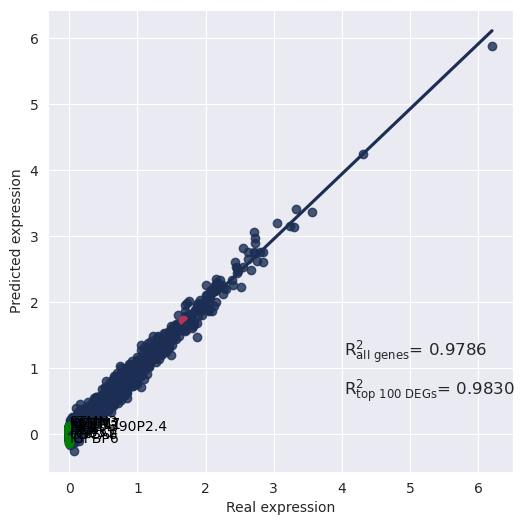

<Figure size 640x480 with 0 Axes>

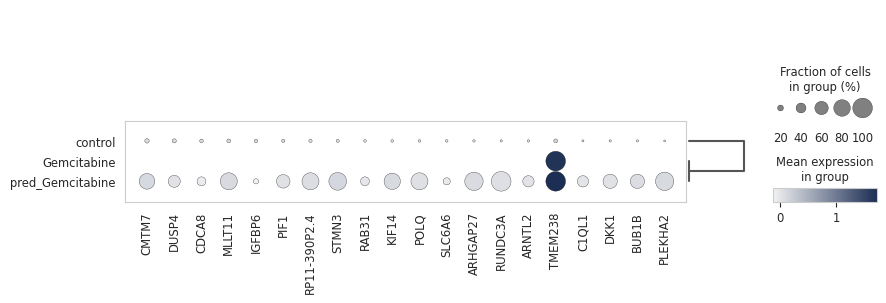

  0%|          | 0/1 [00:00<?, ?it/s]

R2 top 20 DEGs:  -1.56504653923411
R2 top 50 DEGs:  0.38900001524470396
R2 all genes:  0.6851576537169514
R2 top 100 DEGs:  0.7310430533616051
2916


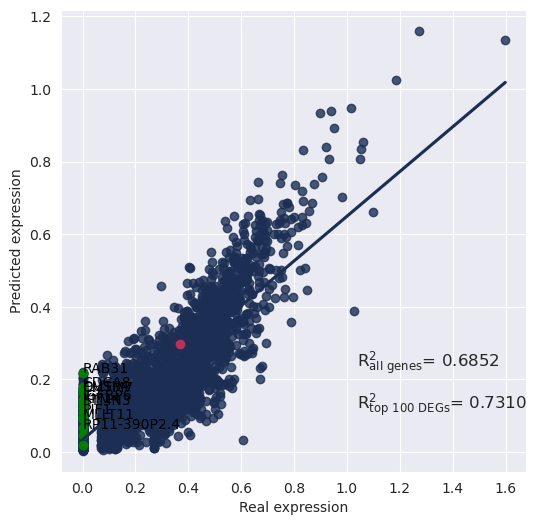

<Figure size 640x480 with 0 Axes>

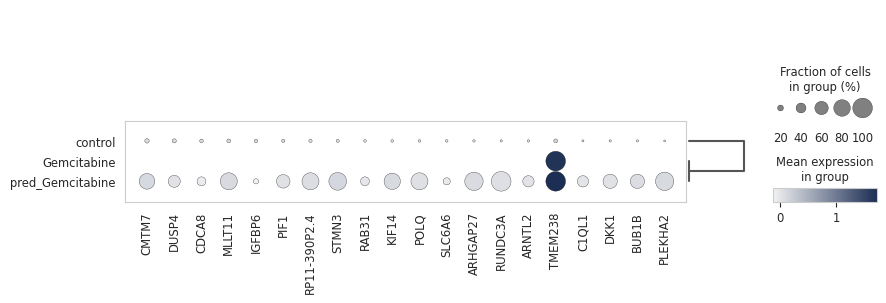

Bortezomib


  0%|          | 0/2 [00:00<?, ?it/s]

R2 top 20 DEGs:  0.9774497654647615
R2 top 50 DEGs:  0.9803696630996848
R2 all genes:  0.9517059333239918
R2 top 100 DEGs:  0.9667796401131511
2916


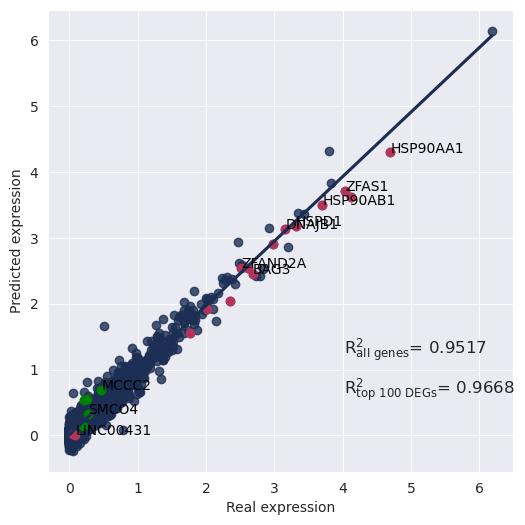

<Figure size 640x480 with 0 Axes>

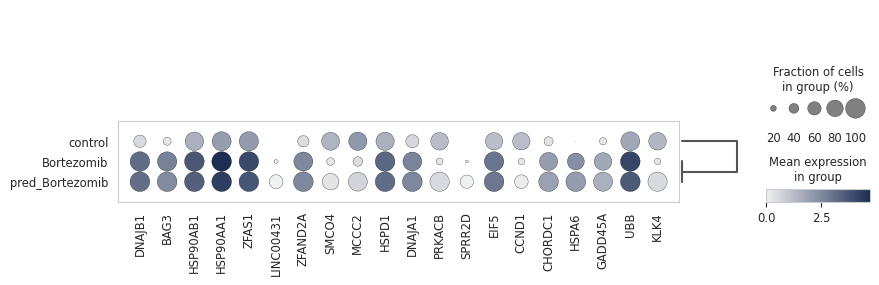

  0%|          | 0/2 [00:00<?, ?it/s]

R2 top 20 DEGs:  0.5381379266314187
R2 top 50 DEGs:  0.7733099073294387
R2 all genes:  0.74093711639145
R2 top 100 DEGs:  0.7335289527390518
2916


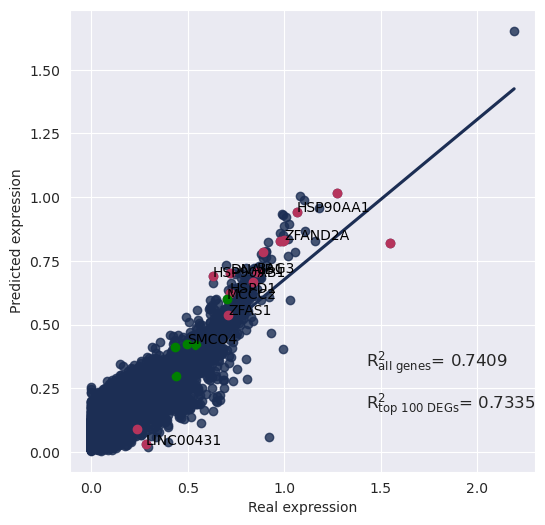

<Figure size 640x480 with 0 Axes>

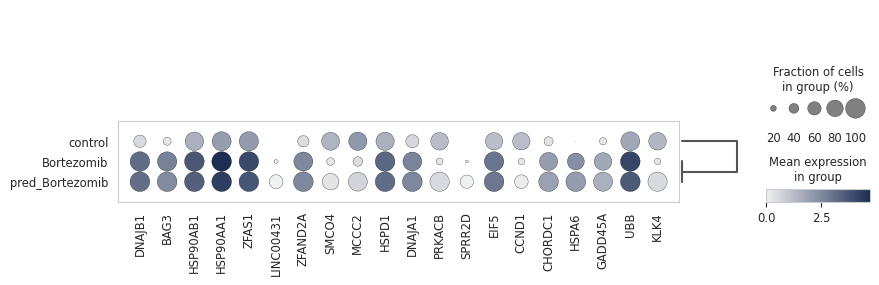

JQ1


  0%|          | 0/1 [00:00<?, ?it/s]

R2 top 20 DEGs:  -74.68536685510027
R2 top 50 DEGs:  0.84563709677718
R2 all genes:  0.9563896706099801
R2 top 100 DEGs:  0.9455917092974352
2916


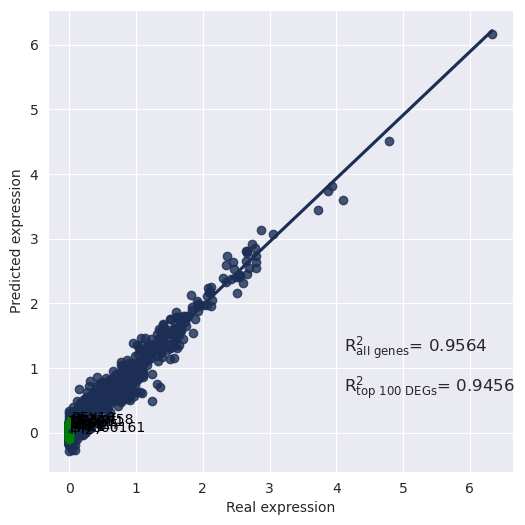

<Figure size 640x480 with 0 Axes>

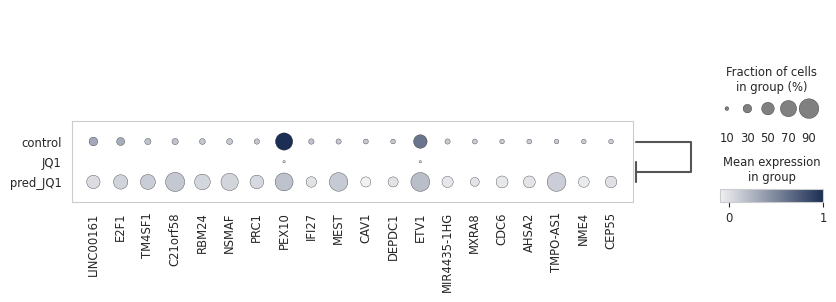

  0%|          | 0/1 [00:00<?, ?it/s]

R2 top 20 DEGs:  -21.295490627787036
R2 top 50 DEGs:  -0.130539286507946
R2 all genes:  0.6801329681845067
R2 top 100 DEGs:  0.498831477639083
2916


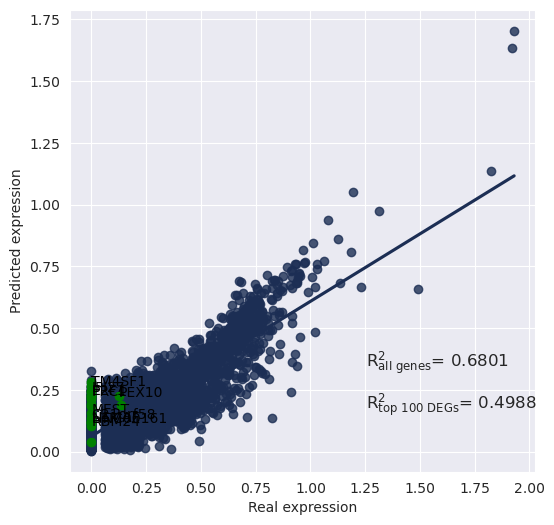

<Figure size 640x480 with 0 Axes>

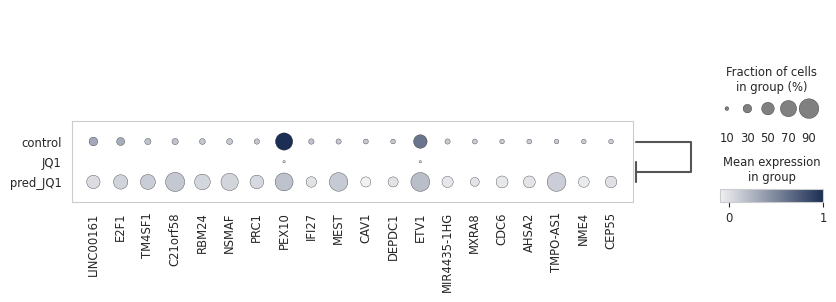

r2_all_avg 0.9622338586798346 r2_degs_avg 0.9651382451878141 r2_all_std 0.7020759127643027 r2_degs_std 0.6544678279132466


In [12]:
from importlib import reload
import utils
reload(utils)
from utils import *
import model
from importlib import reload
reload(model)
from model import *
import optuna

params = {'hidden_channels': 128, 'weight_decay': 1e-05, 'in_head': 4, 'learning_rate': -3, 'num_epochs': 200, 'batch_size': 256}
train_dataloader = DataLoader(cells_train+cells_valid, batch_size=params['batch_size'], shuffle=True)
model = GNN(total_genes  = len(adata.var), num_perts = num_perts, act_fct = 'Sigmoid',
            hidden_channels = params['hidden_channels'], in_head = params['in_head'], all_feat = True).to(device)

model = train(model = model, num_epochs = params['num_epochs'], lr = 10**params['learning_rate'],
            weight_decay = params['weight_decay'],
            cell_type_network = cell_type_network, train_loader = train_dataloader)
torch.save(model.state_dict(), save_path_models+"McFarland_model.pt")
model.load_state_dict(torch.load(save_path_models+"McFarland_model.pt"))
r2_all_avg = []
r2_degs_avg = []
r2_all_std = []
r2_degs_std = []
ood_loader_all = DataLoader(cells_ood, batch_size=len(cells_ood), shuffle=False)
ood_cells = np.array(next(iter(ood_loader_all)).cell_type)
cov_drugs = np.array(next(iter(ood_loader_all)).cov_drug)
pred_adata = []
DEGs_name_drug = {}
for cov_drug in tq.tqdm(set(cov_drugs)):
    testing_drug = cov_drug.split('_')[1]
    ood_cell = cov_drug.split('_')[0]
    index_cell_type = np.where(cov_drugs == cov_drug)[0]
    data = [cells_ood[i] for i in index_cell_type]
    ood_loader_cell_type = DataLoader(data, batch_size=params['batch_size'], shuffle=False)
    if testing_drug != 'control':
        print(testing_drug)
        r2_all, r2_DEGs, DEGs_name, dot_adata =  Inference(cell_type_network, model, 
                   save_path_results+"McFarland_mean_"+testing_drug, ood_loader_cell_type, 
                   ood_cell, adata, testing_drug = testing_drug, 
                   degs_dict = adata.uns['rank_genes_groups_cov_DEGs'][ood_cell+'_'+testing_drug], mean_or_std = True, plot = True)
        r2_all_avg.append(r2_all)
        r2_degs_avg.append(r2_DEGs)
        #---------------------------------------------------------------------------------------------------------
        r2_all, r2_DEGs, DEGs_name, dot_adata = Inference(cell_type_network, model, 
                   save_path_results+"McFarland_std_"+testing_drug, ood_loader_cell_type, 
                   ood_cell, adata, testing_drug = testing_drug, 
                   degs_dict = adata.uns['rank_genes_groups_cov_DEGs'][ood_cell+'_'+testing_drug], mean_or_std = False, plot = True)
        r2_all_std.append(r2_all)
        r2_degs_std.append(r2_DEGs)
        pred_adata.append(dot_adata)
        DEGs_name_drug[testing_drug] = DEGs_name
pred_adata.append(adata[adata.obs.cov_drug == testing_cell+'_control', cell_type_network[testing_cell].pos.tolist()].copy())

print( 'r2_all_avg', np.mean(r2_all_avg),
        'r2_degs_avg', np.mean(r2_degs_avg),
        'r2_all_std', np.mean(r2_all_std),
        'r2_degs_std', np.mean(r2_degs_std) )

## Visualize the UMAP of Observed and Predicted Expression

AnnData object with n_obs × n_vars = 1392 × 2916
    obs: 'DepMap_ID', 'cancer', 'cell_det_rate', 'cell_type', 'cell_quality', 'channel', 'disease', 'dose_unit', 'dose_value', 'doublet_CL1', 'doublet_CL2', 'doublet_GMM_prob', 'doublet_dev_imp', 'doublet_z_margin', 'hash_assignment', 'hash_tag', 'num_SNPs', 'organism', 'percent.mito', 'condition', 'perturbation_type', 'sex', 'singlet_ID', 'singlet_dev', 'singlet_dev_z', 'singlet_margin', 'singlet_z_margin', 'time', 'tissue_type', 'tot_reads', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo', 'chembl-ID', 'n_counts', 'drug_dose_name', 'cov_drug_dose_name', 'cov_drug', 'condition_label', 'SEACell', 'split'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/alsulara/miniconda3/envs/Perturb

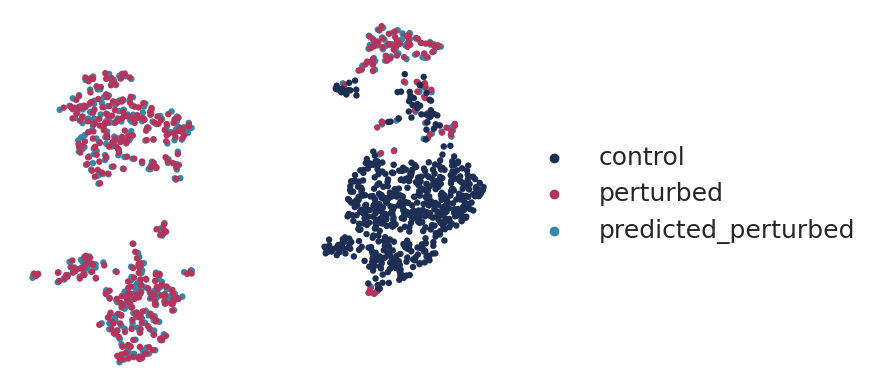

In [13]:
pred_adata_all = sc.concat(pred_adata, join='outer')
display(pred_adata_all)
pred_adata_all.obs['Condition'] = 'perturbed'
pred_adata_all.obs.loc[pred_adata_all.obs.condition == 'control','Condition'] = 'control'
pred_adata_all.obs.loc[pred_adata_all.obs['condition'].str.startswith('pred'), 'Condition'] = 'predicted_perturbed'
pred_adata_all.obs.rename(columns={'Condition': 'Treatment'}, inplace=True) 

sc.pp.neighbors(pred_adata_all)
sc.tl.umap(pred_adata_all) 

fig, ax = plt.subplots()
custom_colors = {'control': '#1C2E54', 'perturbed': '#B5345C', 'predicted_perturbed':'#3487A7'}
sc.pl.umap(pred_adata_all, color='Treatment',  ax=ax, show=False, palette=list(custom_colors.values()), frameon=False, legend_fontsize=18)
# Remove the box (spines) around the plot
ax.set_title('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)